<a href="https://colab.research.google.com/github/farnoosh-afshinrad/corn-disease-prediction/blob/main/corn_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Corn Disease Prediction Based on Autoencoders (AE)




In this project we will see how we can use Autoencoders in this case Convolutional AE as a classifier in multi-class classification task. you can find the dataset of the project [here](https://www.kaggle.com/smaranjitghose/corn-or-maize-leaf-disease-dataset). But I dicreased the size of all class due to RAM capacity issues in training process. In order to get more familiar with my mindset in this project , at the first place, I briefly explain what did I do. 

* mounting google drive on colab and visualizing some of the images we are going to work with
* Finding out the mean of the dimentions and resizing all images accordingly.
* Converting images into a numpy array and normalize them. Before, checking class imbalance
* Splitting data and performing one-hot encoder
* Constructed the convoltonal autoencoder model: going through modeling the data and forming the network
* Then, defined a classifier AE based on the presented AE and re-train the model 
* Provided a classification report at the end of the codes


In [ ]:
#mounting Google Drive on Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Colab_Notebooks/corn/data"

/content/drive/My Drive/Colab_Notebooks/corn/data


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Input, Reshape, UpSampling2D,Conv2DTranspose, merge
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    moving_mean_initializer="zeros",
    moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
)

In [ ]:
#just to make sure how many and what types of classes we have
path = "/content/drive/My Drive/Colab_Notebooks/corn/data/"
os.listdir(path)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [ ]:
#Converting Images to array 
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (128,128))  
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
dir = '/content/drive/My Drive/Colab_Notebooks/corn/data'
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Common_Rust ', 'Healthy', 'Blight', 'Gray_Leaf_Spot']
binary_labels = [0,1,2,3]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
  corn_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in corn_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(directory)

In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

Common_Rust       310
Healthy           301
Blight            301
Gray_Leaf_Spot    176
dtype: int64

In [ ]:
image_list[0].shape

(128, 128, 3)

In [ ]:
label_list = np.array(label_list)
label_list.shape

(1088,)

In [ ]:
# Storing number of classes
num_classes = len(label_counts)
num_classes

4

In [ ]:
# Splitting dataset
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list , test_size=0.2, random_state = 42) 

In [ ]:
# Label binarizing
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['Blight' 'Common_Rust' 'Gray_Leaf_Spot' 'Healthy']


In [ ]:
# Normalize and reshape data
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0
x_train = x_train.reshape( -1, 128,128,3)
x_test = x_test.reshape( -1, 128,128,3)

In [ ]:
x_train.shape

(870, 128, 128, 3)

In [ ]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2,  random_state = 42)

In [ ]:
batch_size = 64
epochs = 32
inChannel = 3
x, y = 128, 128
input_img = Input(shape = ( x, y, inChannel))

In [ ]:
def encoder(input_img):
    #encoder
    #input = 128 x 128 x 3 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = tf.keras.layers.BatchNormalization()(conv4) 
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4) 
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) 
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv6 = tf.keras.layers.BatchNormalization()(conv6) 
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv7 = tf.keras.layers.BatchNormalization()(conv7) 
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

In [ ]:
def encoder(input_img):
    #encoder
    #input = 128 x 128 x 3 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) 
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    return conv4

In [ ]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [ ]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [ ]:
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0     

In [ ]:
full_model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])

In [ ]:
classify_train = full_model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/32
11/11 [==============================] - 201s 18s/step - loss: 20.8664 - accuracy: 0.5876 - val_loss: 20.6665 - val_accuracy: 0.3218
Epoch 2/32
11/11 [==============================] - 190s 17s/step - loss: 5.4426 - accuracy: 0.6422 - val_loss: 29.0481 - val_accuracy: 0.3391
Epoch 3/32
11/11 [==============================] - 192s 18s/step - loss: 5.6145 - accuracy: 0.7112 - val_loss: 36.3678 - val_accuracy: 0.4770
Epoch 4/32
11/11 [==============================] - 195s 18s/step - loss: 3.2899 - accuracy: 0.7069 - val_loss: 58.1802 - val_accuracy: 0.3391
Epoch 5/32
11/11 [==============================] - 191s 17s/step - loss: 1.0800 - accuracy: 0.7241 - val_loss: 8.1486 - val_accuracy: 0.3908
Epoch 6/32
11/11 [==============================] - 190s 17s/step - loss: 1.0220 - accuracy: 0.7328 - val_loss: 6.6834 - val_accuracy: 0.4483
Epoch 7/32
11/11 [==============================] - 194s 18s/step - loss: 0.7617 - accuracy: 0.7500 - val_loss: 5.6613 - val_accuracy: 0.2931
E

In [ ]:
# Saving model
full_model.save("/content/drive/My Drive/Colab_Notebooks/corn/corn_disease.h5")

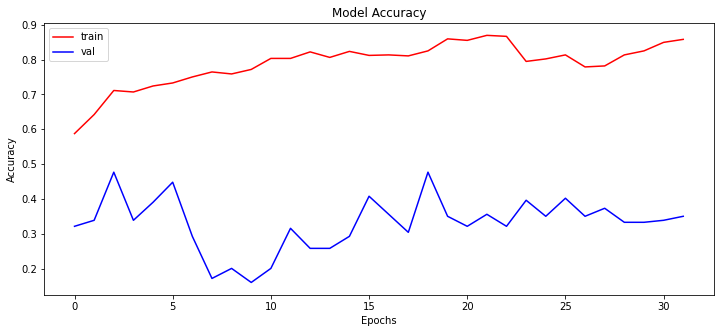

In [ ]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(classify_train.history['accuracy'], color='r')
plt.plot(classify_train.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

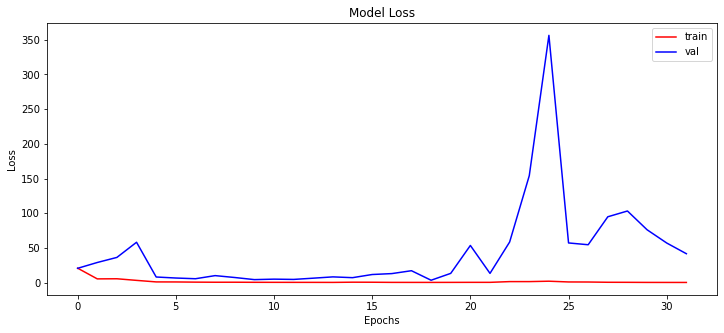

In [ ]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(classify_train.history['loss'], color='r')
plt.plot(classify_train.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# Calculating test accuracy
scores = full_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

7/7 [==============================] - 13s 2s/step - loss: 65.2744 - accuracy: 0.2661
Test Accuracy: 26.605504751205444


In [ ]:
# Storing predictions
y_pred = full_model.predict(x_test)

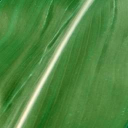

In [ ]:
# Plotting image to compare
img = array_to_img(x_test[6])
img

In [ ]:
# Finding max value from predition list and comaparing original value vs predicted
labels = lb.classes_
print(labels)
print("Originally : ",labels[np.argmax(y_test[6])])
print("Predicted : ",labels[np.argmax(y_pred[6])])

['Blight' 'Common_Rust' 'Gray_Leaf_Spot' 'Healthy']
Originally :  Healthy
Predicted :  Healthy


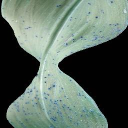

In [ ]:
img = array_to_img(x_test[2])
img

In [ ]:
labels = lb.classes_
print(labels)
print("Originally : ",labels[np.argmax(y_test[2])])
print("Predicted : ",labels[np.argmax(y_pred[2])])

['Blight' 'Common_Rust' 'Gray_Leaf_Spot' 'Healthy']
Originally :  Common_Rust
Predicted :  Healthy


Although we tried to resize the images to enhace training process, it is obvious that it decreases the accuracy extremely. 

Also, this model can be mainly accurate for the "Healthy" category. because in these sort of images we do not have many details. 

As I tried different values for different elements, I guess the best performence of this model would be achieved by (256, 256, 3) image shape with more than 200 epochs. 

# **THANKS FOR YOUR TIME AND CONSIDERATION**